# Analyzing experiment from 10/7/2015  
Because there's a dropped frame or some misalignment we JUST (3-31-2016) noticed in the middle

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io
import itertools
import os
import h5py
import pyret.visualizations as pyviz
import pyret.filtertools as ft
import pyret.spiketools as st
import jetpack
from experiments.iotools import read_channel # from niru-analysis github
from experiments.photodiode import find_peaks, find_start_times
# import binary     # in igor >> recording
import pdb
import string
# from jetpack.signals import peakdet
from scipy.signal import find_peaks_cwt
from os.path import expanduser

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow

# note that nonposx(y) for log plots will no longer work with this package
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## experiment directory

In [2]:
data_dir = '/Users/lmcintosh/experiments/data/15-10-07/'
stim_dir = '/Users/lmcintosh/experiments/data/15-10-07/'
stimulus_filename = 'stimulus.h5'

## load spikes

In [3]:
fs = sorted(os.listdir(data_dir))
fs = [f for f in fs if f.endswith(".txt")]

cells = []
for f in fs:
    text_file = open(data_dir + f, "r")
    spikes = text_file.read().split()
    cells.append([float(spike) for spike in spikes if (not (not spike)) and float(spike) > 0])
    
    text_file.close()

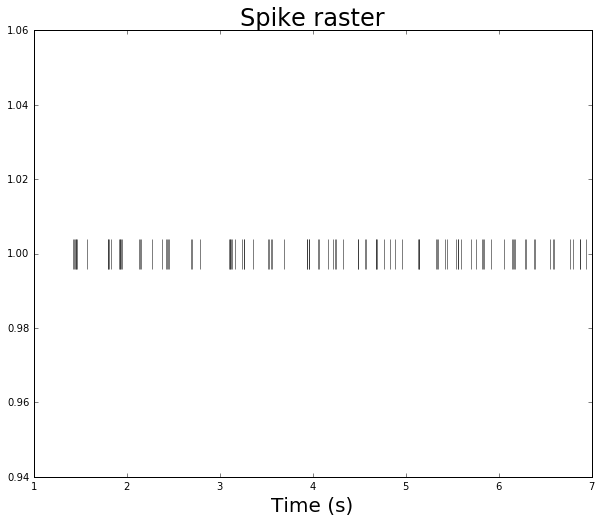

In [4]:
fig = pyviz.raster(cells[0][:100], np.ones((len(cells[0][:100]),)), marker_string='|', color='k', markersize=30)

## load stimulus

In [32]:
f = h5py.File(stim_dir + stimulus_filename)
list(f)

[u'cell01',
 u'cell02',
 u'cell03',
 u'cell04',
 u'cell05',
 u'cell06',
 u'cell07',
 u'cell08',
 u'cell09',
 u'expt1',
 u'expt10',
 u'expt11',
 u'expt12',
 u'expt13',
 u'expt14',
 u'expt15',
 u'expt16',
 u'expt17',
 u'expt18',
 u'expt19',
 u'expt2',
 u'expt20',
 u'expt21',
 u'expt22',
 u'expt23',
 u'expt24',
 u'expt3',
 u'expt4',
 u'expt5',
 u'expt6',
 u'expt7',
 u'expt8',
 u'expt9']

In [33]:
list(f['expt1'])

[u'start_time', u'stim', u'stop_time', u'timestamps']

In [34]:
(f['expt1/stim'].shape, f['expt1/timestamps'].shape)

((19989, 50, 50), (19989,))

## find peaks in photodiode to align each experiment

#### load photodiode

In [16]:
photodiode_dir = '/Volumes/group/baccus/Lane/2015-10-07/' + 'photodiode_times/'
photodiode_filenames = ['photo_a.p', 'photo_b.p', 'photo_c.p', 'photo_d.p', 'photo_e.p', 'photo_f.p', 'photo_g.p', 'photo_h.p', 'photo_i.p']
photodiode_filename = 'photo.p'

In [17]:
import pickle

In [18]:
with open(photodiode_dir + photodiode_filename) as f:
    pd = pickle.load(f)

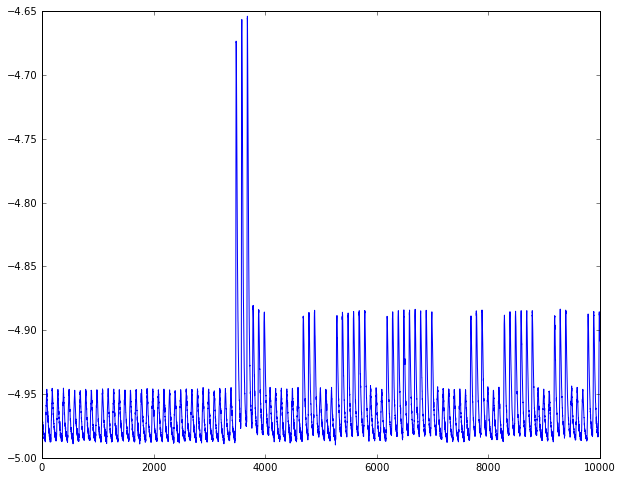

In [19]:
plt.plot(pd[10000:20000])

#### below is a photodiode trace from 16-01-07

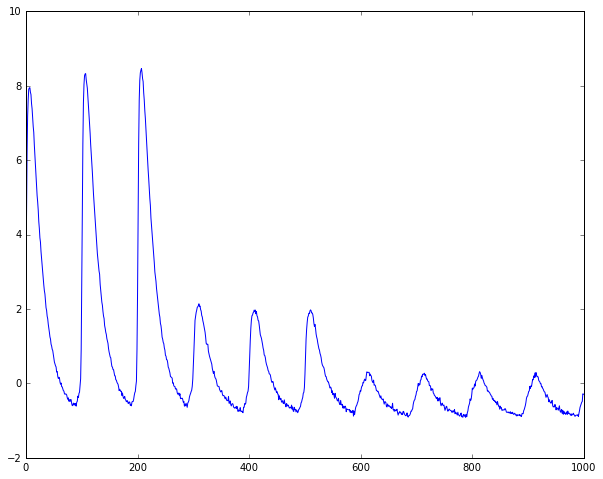

In [9]:
plt.plot(pd[:1000])

#### find peaks

In [20]:
# delta is the threshold for accepting optima; i.e. optima must be delta greater than neighboring values
# delta = 1.0 # this finds all photodiode peaks
delta = 0.28 #0.28 #0.3 # below .28 you get thousands of hits
maxtab = find_peaks(pd, delta)

➛ Finding peaks (can take a minute)... 
Done! ✔


In [21]:
# expectation of maxtab shape is 24 experiments * 3 flips per frame = 72
maxtab.shape

(69, 2)

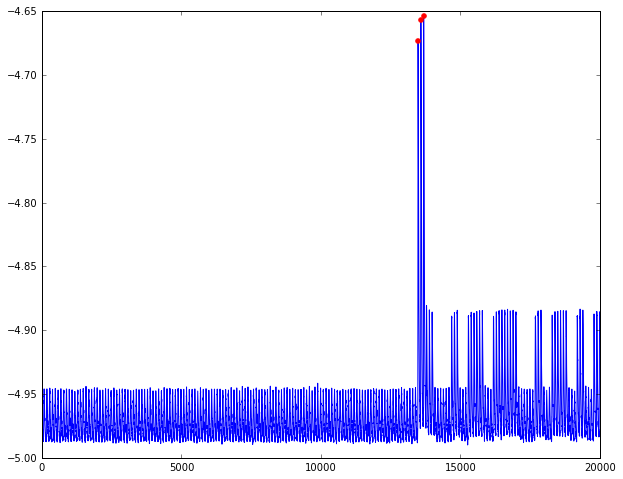

In [22]:
plt.plot(pd[:20000])
# plt.plot(maxtab[:50, 0], maxtab[:50, 1], 'r.', markersize=10)
plt.plot(maxtab[:3, 0], maxtab[:3, 1], 'r.', markersize=10)

In [23]:
maxtab

array([[  1.34800000e+04,  -4.67330933e+00],
       [  1.35820000e+04,  -4.65637207e+00],
       [  1.36820000e+04,  -4.65377808e+00],
       [  6.01438800e+06,  -4.66918945e+00],
       [  6.01448700e+06,  -4.66369629e+00],
       [  6.01458700e+06,  -4.66354370e+00],
       [  6.73589300e+06,  -4.68139648e+00],
       [  6.73599200e+06,  -4.66400146e+00],
       [  6.73609400e+06,  -4.66430664e+00],
       [  1.28608870e+07,  -4.68292236e+00],
       [  1.28609870e+07,  -4.66705322e+00],
       [  1.28610880e+07,  -4.66140747e+00],
       [  1.34621080e+07,  -4.66598511e+00],
       [  1.34622090e+07,  -4.66186523e+00],
       [  1.34623080e+07,  -4.66140747e+00],
       [  1.94631150e+07,  -4.67575073e+00],
       [  1.94632150e+07,  -4.66629028e+00],
       [  1.94633150e+07,  -4.66369629e+00],
       [  2.01845210e+07,  -4.68322754e+00],
       [  2.01846210e+07,  -4.66552734e+00],
       [  2.01847200e+07,  -4.66369629e+00],
       [  2.63097150e+07,  -4.68490601e+00],
       [  

In [24]:
start_times = find_start_times(maxtab, flips_per_frame=3, refresh_rate=100, threshold=.2)

Found 23 different stimulus sequences at the following times:
Stimulus # 1 started at t = 1.3682 s
Stimulus # 2 started at t = 10 min., 1.4587 s
Stimulus # 3 started at t = 11 min., 13.6094 s
Stimulus # 4 started at t = 21 min., 26.1088 s
Stimulus # 5 started at t = 22 min., 26.2308 s
Stimulus # 6 started at t = 32 min., 26.3315 s
Stimulus # 7 started at t = 33 min., 38.472 s
Stimulus # 8 started at t = 43 min., 50.9915 s
Stimulus # 9 started at t = 44 min., 51.1337 s
Stimulus #10 started at t = 54 min., 51.2345 s
Stimulus #11 started at t = 56 min., 3.3849 s
Stimulus #12 started at t = 1 hours, 6 min., 15.9645 s
Stimulus #13 started at t = 1 hours, 7 min., 16.1267 s
Stimulus #14 started at t = 1 hours, 17 min., 16.2274 s
Stimulus #15 started at t = 1 hours, 18 min., 28.378 s
Stimulus #16 started at t = 1 hours, 28 min., 40.8474 s
Stimulus #17 started at t = 1 hours, 29 min., 40.9897 s
Stimulus #18 started at t = 1 hours, 39 min., 41.0904 s
Stimulus #19 started at t = 1 hours, 40 min.,

## account for taking the third photodiode flash

In [29]:
offset = 0.02 # shifting stimulus 20 ms ahead since we're taking the 3rd photodiode
start_times = start_times - offset

In [35]:
f['expt1/timestamps'][-1]

600.05628999999317

# Align spikes with each experiment

In [36]:
expt_spikes = []
for expt_id, start in enumerate(start_times):
    expt_spikes.append([])
    expt_name = 'expt%d' %(expt_id+1)
    stop = f[expt_name + '/timestamps'][-1] # last timestamp, in seconds
    for c in cells:
        expt_spikes[-1].append([sp-start for sp in c if sp >= start and sp <= start+stop])

In [37]:
def spikes_to_array(spikes):
    '''
    Converts a list of spike times to an array with labels for easy
    pyret.visualizations.raster() use.
    
    INPUT:
        spikes    list of list of spike times
    '''
    collapsed_spikes = []
    collapsed_labels = []
    nlists = len(spikes)
    for idl, l in enumerate(spikes):
        labels = idl * np.ones((len(l),))
        collapsed_spikes.extend(l)
        collapsed_labels.extend(labels)
        
    return np.array(collapsed_spikes), np.array(collapsed_labels)
    

In [38]:
all_spikes, all_labels = spikes_to_array(expt_spikes[1])

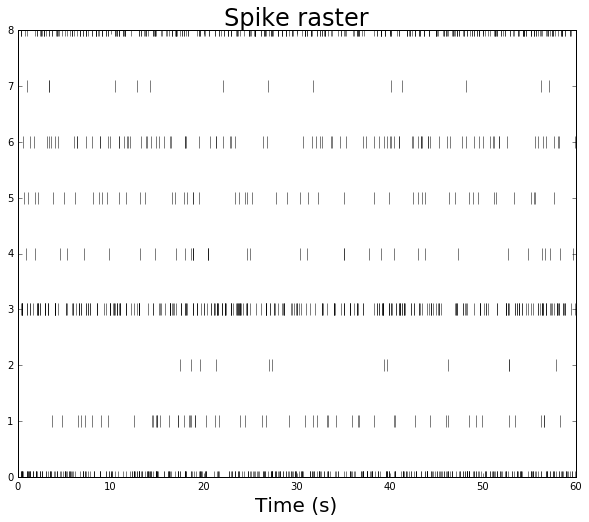

In [39]:
fig = pyviz.raster(all_spikes, all_labels, marker_string='|', color='k', markersize=12)

# look at trial-to-trial variability of a single cell to repeated natural scenes

In [66]:
naturalscene_spikes = []
naturalscene_labels = []
for c in range(len(cells)):
    cell_idx = c
    first_trial = 3
    num_diff_trials = 4
    total_trials = 23
    repeats = []
    for t in range(first_trial, total_trials, num_diff_trials):
        repeats.append(expt_spikes[t][cell_idx])

    all_spikes, all_labels = spikes_to_array(repeats)
    naturalscene_spikes.append(all_spikes)
    naturalscene_labels.append(all_labels)

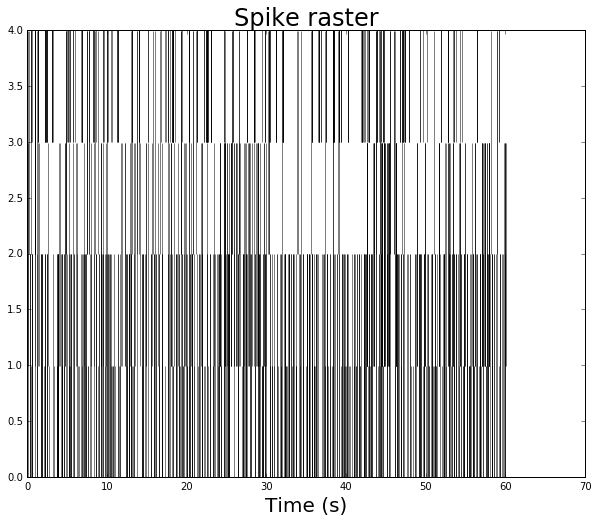

In [67]:
fig = pyviz.raster(all_spikes, all_labels, marker_string='|', color='k', markersize=223)

# save natural scene repeats as an h5 file

In [49]:
naturalscene_spikes = all_spikes
naturalscene_labels = all_labels

# look at trial-to-trial variability of a single cell to repeated white noise

In [64]:
whitenoise_spikes = []
whitenoise_labels = []
for c in range(len(cells)):
    cell_idx = c
    first_trial = 1
    num_diff_trials = 4
    total_trials = 24
    repeats = []
    for t in range(first_trial, total_trials, num_diff_trials):
        repeats.append(expt_spikes[t][cell_idx])

    all_spikes, all_labels = spikes_to_array(repeats)
    whitenoise_spikes.append(all_spikes)
    whitenoise_labels.append(all_labels)
    

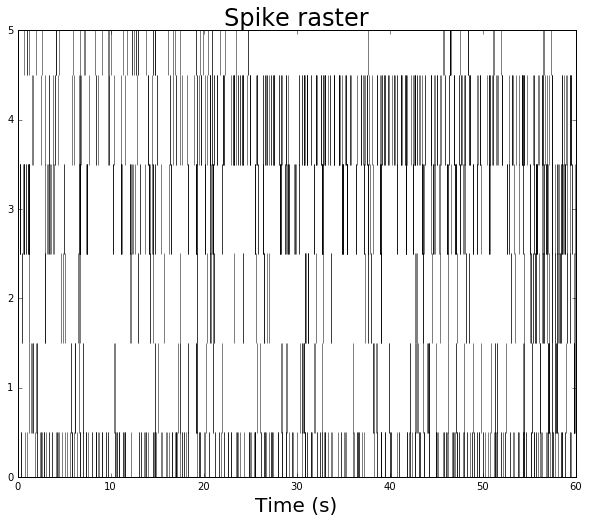

In [65]:
fig = pyviz.raster(all_spikes, all_labels, marker_string='|', color='k', markersize=90)

# save all repeats to an h5 file

In [69]:
with h5py.File('/Users/lmcintosh/experiments/data/15-10-07/repeats.h5', 'w') as g:
    for c in range(len(cells)):
        g.create_dataset('whitenoise/spikes/cell%0i' %(c+1), data=whitenoise_spikes[c])
        g.create_dataset('whitenoise/labels/cell%0i' %(c+1), data=whitenoise_labels[c])
        g.create_dataset('naturalscene/spikes/cell%0i' %(c+1), data=naturalscene_spikes[c])
        g.create_dataset('naturalscene/labels/cell%0i' %(c+1), data=naturalscene_labels[c])

# let's look at the non-repeated natural scenes

In [137]:
cell_idx = 0
first_trial = 2
num_diff_trials = 4
total_trials = 24
repeats = []
for t in range(first_trial, total_trials, num_diff_trials):
    repeats.append(expt_spikes[t][cell_idx])

all_spikes, all_labels = spikes_to_array(repeats)

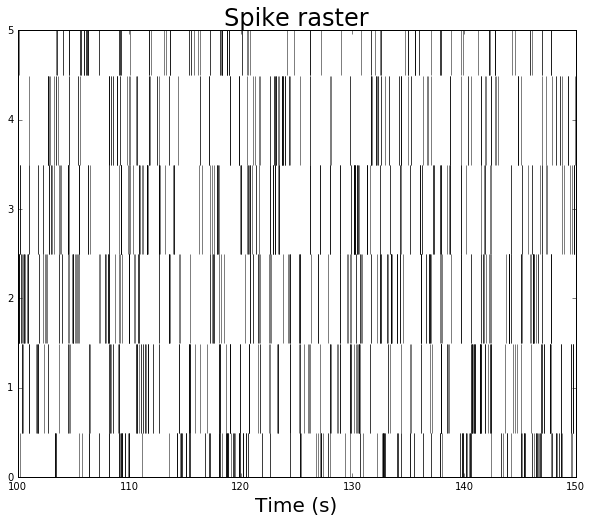

In [171]:
fig = plt.gcf()
# ax = plt.gca()
fig = pyviz.raster(all_spikes, all_labels, marker_string='|', color='k', markersize=89, xlim=[100,150])
# ax.set_xlim([100,200])

# of course there shouldn't have any structure... this is non-repeated

In [172]:
len(cells)

9

In [173]:
import brewer2mpl

In [174]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

(0, 60)

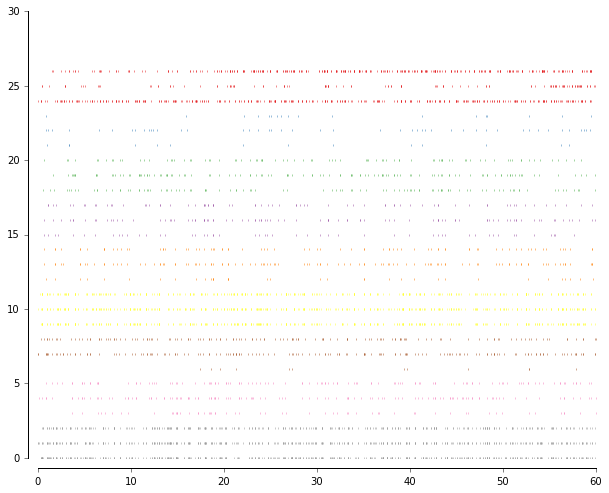

In [175]:
ax = plt.gca()
bmap = brewer2mpl.get_map('Set1', 'Qualitative', 9, reverse=True)
colors = bmap.mpl_colors

# structured stimuli
first_trial = 1
num_diff_trials = 8
total_trials = 24
num_repeats = 3
for c in range(len(cells)):
    repeats = []
    for t in range(first_trial, total_trials, num_diff_trials):
        repeats.append(expt_spikes[t][c])

    all_spikes, all_labels = spikes_to_array(repeats)
    all_labels += num_repeats * c
    
    # plot raster for this particular cell
    which_color = c % 9
    ax.plot(all_spikes, all_labels, '|', markersize=2, color=colors[which_color])

plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.xlim([0, 60])

# Check out the STAs for the 9 cells

In [176]:
from scipy.stats import zscore
import pyret.stimulustools as stimtools

In [177]:
# cell_idx = 0
# first_trial = 7
# num_diff_trials = 8
# total_trials = 24

stas = []

whitenoise_expts = range(0,24,8)
for c in range(len(cells)):
    partial_sta = np.zeros((40, 50, 50))
    for expt_id in whitenoise_expts:
        expt_name = 'expt%d' %(expt_id+1)
        time = f[expt_name + '/timestamps']
        stimulus = zscore(f[expt_name + '/stim'])
        stimulus_upsample, time_upsample = stimtools.upsample_stim(stimulus, 3, time)
        sta, tax = ft.getsta(time_upsample, stimulus_upsample, expt_spikes[expt_id][c], 40)
        partial_sta += sta
    partial_sta /= len(whitenoise_expts)
    stas.append(partial_sta)

In [178]:
len(stas)

9

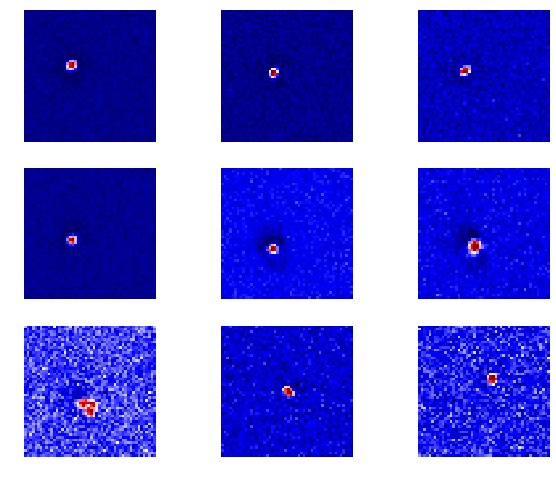

In [179]:
num_cols = 3
num_rows = 3
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        if plt_idx <= len(cells):
            space, time = ft.decompose(stas[plt_idx-1])

            plt.subplot(num_rows, num_cols, plt_idx)
            plt.imshow(space - np.mean(space), cmap='seismic')
            plt.axis('off')

#### save STAs

In [180]:
from deepretina.visualizations import visualize_sta

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, CuDNN not available)


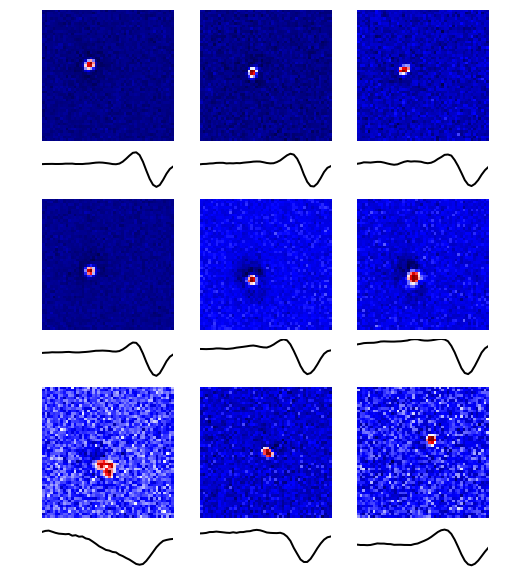

In [181]:
stas_array = np.array(stas)
visualize_sta(stas_array, normalize=False)

In [182]:
for c in range(len(cells)):
    space, time = ft.decompose(stas[c])
    plt.imshow(space - np.mean(space), cmap='seismic')
    plt_filename = 'sta_cell_%d.png' %(c)
    plt.savefig(plt_filename)
    plt.close()

# Save stimulus and responses in h5 files

In [183]:
import h5py
from pyret.spiketools import binspikes

#### expts to each stim type

In [184]:
whitenoise_train_expts = [0, 4, 8, 12, 16, 20]
whitenoise_test_expts = [1, 5, 9, 13, 17, 21]
naturalscene_train_expts = [2, 6, 10, 14, 18, 22]
naturalscene_test_expts = [3, 7, 11, 15, 19]

#### whitenoise

In [186]:
h = h5py.File('/Users/lmcintosh/experiments/data/15-10-07/whitenoise_3_31_2016.h5', 'w')

##### spikes #####
ncells = len(cells)
for idx in range(ncells):
    h.create_dataset('spikes/cell%02d' %(idx+1), data=np.array(cells[idx]))

##### train #####
train_stimuli = []
train_times = []
train_response_binned = []
train_response_5ms = []
train_response_10ms = []
train_response_20ms = []
last_time = 0.0
for idx in whitenoise_train_expts:
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
    train_response_binned.append(np.vstack(binned_spikes))
    train_response_5ms.append(np.vstack(response_5ms))
    train_response_10ms.append(np.vstack(response_10ms))
    train_response_20ms.append(np.vstack(response_20ms))
    train_stimuli.append(stimulus_upsample[:-1])
    train_times.append(time_upsample[:-1] + last_time)
    last_time += time_upsample[-1]
# create datasets
h.create_dataset('train/stimulus', data=np.vstack(train_stimuli))
h.create_dataset('train/time', data=np.hstack(train_times))
h.create_dataset('train/response/binned', data=np.hstack(train_response_binned))
h.create_dataset('train/response/firing_rate_10ms', data=np.hstack(train_response_10ms))
h.create_dataset('train/response/firing_rate_20ms', data=np.hstack(train_response_20ms))
h.create_dataset('train/response/firing_rate_5ms', data=np.hstack(train_response_5ms))

##### test #####
test_stimuli = []
test_times = []
test_response_binned = []
test_response_5ms = []
test_response_10ms = []
test_response_20ms = []
test_repeats = []
for repeat, idx in enumerate(whitenoise_test_expts):
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
        if repeat == 0:
            test_repeats.append([r10ms])
        else:
            test_repeats[c].append(r10ms)
    test_response_binned.append(np.vstack(binned_spikes))
    test_response_5ms.append(np.vstack(response_5ms))
    test_response_10ms.append(np.vstack(response_10ms))
    test_response_20ms.append(np.vstack(response_20ms))
# create datasets
h.create_dataset('test/stimulus', data=stimulus_upsample[:-1])
h.create_dataset('test/time', data=time_upsample[:-1])
h.create_dataset('test/response/binned', data=np.mean(test_response_binned, axis=0))
h.create_dataset('test/response/firing_rate_10ms', data=np.mean(test_response_10ms, axis=0))
h.create_dataset('test/response/firing_rate_20ms', data=np.mean(test_response_20ms, axis=0))
h.create_dataset('test/response/firing_rate_5ms', data=np.mean(test_response_5ms, axis=0))
for c in range(len(cells)):
    dataset_name = 'test/repeats/cell%02d' %(c+1)
    h.create_dataset(dataset_name, data=np.vstack(test_repeats[c]))

h.close()

#### naturalscenes

In [187]:
h = h5py.File('/Users/lmcintosh/experiments/data/15-10-07/naturalscene_3_31_2016.h5', 'w')

##### spikes #####
ncells = len(cells)
for idx in range(ncells):
    h.create_dataset('spikes/cell%02d' %(idx+1), data=np.array(cells[idx]))

##### train #####
train_stimuli = []
train_times = []
train_response_binned = []
train_response_5ms = []
train_response_10ms = []
train_response_20ms = []
last_time = 0.0
for idx in naturalscene_train_expts:
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
    train_response_binned.append(np.vstack(binned_spikes))
    train_response_5ms.append(np.vstack(response_5ms))
    train_response_10ms.append(np.vstack(response_10ms))
    train_response_20ms.append(np.vstack(response_20ms))
    train_stimuli.append(stimulus_upsample[:-1])
    train_times.append(time_upsample[:-1] + last_time)
    last_time += time_upsample[-1]
# create datasets
h.create_dataset('train/stimulus', data=np.vstack(train_stimuli))
h.create_dataset('train/time', data=np.hstack(train_times))
h.create_dataset('train/response/binned', data=np.hstack(train_response_binned))
h.create_dataset('train/response/firing_rate_10ms', data=np.hstack(train_response_10ms))
h.create_dataset('train/response/firing_rate_20ms', data=np.hstack(train_response_20ms))
h.create_dataset('train/response/firing_rate_5ms', data=np.hstack(train_response_5ms))

##### test #####
test_stimuli = []
test_times = []
test_response_binned = []
test_response_5ms = []
test_response_10ms = []
test_response_20ms = []
test_repeats = []
for repeat, idx in enumerate(naturalscene_test_expts):
    expt_name = 'expt%d' %(idx+1)
    stim = f[expt_name + '/stim']
    time = f[expt_name + '/timestamps']
    stimulus_upsample, time_upsample = stimtools.upsample_stim(stim, 3, time)
    binned_spikes = []
    response_5ms = []
    response_10ms = []
    response_20ms = []
    for c in range(len(cells)):
        bspk, tax = binspikes(expt_spikes[idx][c], binsize=0.01, time=time_upsample)
        binned_spikes.append(bspk)
        to_firing_rate = 1./np.mean(np.diff(time_upsample))
        r5ms = st.estfr(tax, bspk, sigma=0.005) # 5 ms Gaussian
        r10ms = st.estfr(tax, bspk, sigma=0.01) # 10 ms Gaussian
        r20ms = st.estfr(tax, bspk, sigma=0.02) # 20 ms Gaussian
        response_5ms.append(r5ms)
        response_10ms.append(r10ms)
        response_20ms.append(r20ms)
        if repeat == 0:
            test_repeats.append([r10ms])
        else:
            test_repeats[c].append(r10ms)
    test_response_binned.append(np.vstack(binned_spikes))
    test_response_5ms.append(np.vstack(response_5ms))
    test_response_10ms.append(np.vstack(response_10ms))
    test_response_20ms.append(np.vstack(response_20ms))
# create datasets
h.create_dataset('test/stimulus', data=stimulus_upsample[:-1])
h.create_dataset('test/time', data=time_upsample[:-1])
h.create_dataset('test/response/binned', data=np.mean(test_response_binned, axis=0))
h.create_dataset('test/response/firing_rate_10ms', data=np.mean(test_response_10ms, axis=0))
h.create_dataset('test/response/firing_rate_20ms', data=np.mean(test_response_20ms, axis=0))
h.create_dataset('test/response/firing_rate_5ms', data=np.mean(test_response_5ms, axis=0))
for c in range(len(cells)):
    dataset_name = 'test/repeats/cell%02d' %(c+1)
    h.create_dataset(dataset_name, data=np.vstack(test_repeats[c]))

h.close()

# Verify that you can get STAs from the saved h5 files

In [188]:
import numpy as np
import h5py
import pyret.filtertools as ft
from scipy.stats import zscore
import matplotlib.pyplot as plt
%matplotlib inline

In [189]:
f = h5py.File('/Users/lmcintosh/experiments/data/15-10-07/whitenoise.h5', 'r')

In [190]:
list(f['train'])

[u'response', u'stimulus', u'time']

In [191]:
list(f['train/response'])

[u'binned', u'firing_rate_10ms', u'firing_rate_20ms', u'firing_rate_5ms']

In [192]:
stimulus = f['train/stimulus']
firing_rate = f['train/response/firing_rate_10ms']

In [193]:
stimulus.shape

(359802, 50, 50)

In [194]:
cell_idx = 0
stim = zscore(stimulus)
sta = np.zeros((40,50,50))
for idx, response in enumerate(firing_rate[cell_idx]):
    if idx >= 40:
        sta += response * stim[idx-40:idx]

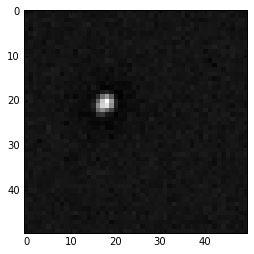

In [195]:
space, time = ft.decompose(sta)
plt.imshow(space)

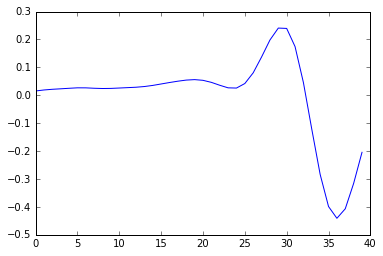

In [196]:
%matplotlib inline
plt.plot(time)

In [197]:
f.close()

## Check that train and test data are on same scale

In [198]:
f = h5py.File('/Users/lmcintosh/experiments/data/16-01-07/naturalmovie.h5', 'r')

In [199]:
train_segment = np.array(f['train/response/firing_rate_10ms'])
test_segment = np.array(f['test/response/firing_rate_10ms'])

In [200]:
train_segment.shape

(33, 180357)

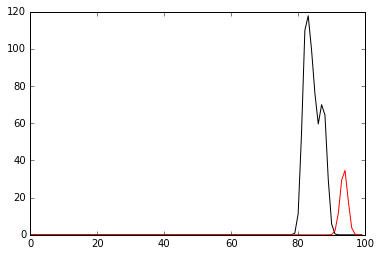

In [201]:
plt.plot(train_segment[0,:100], 'k')
plt.plot(test_segment[0,:100], 'r')

In [202]:
f.close()

# Verify that old and new whitenoise.h5 are the same (they should be)

In [206]:
f_new = h5py.File(os.path.expanduser('~/experiments/data/15-10-07/naturalscene_3_31_2016.h5'), 'r')
f_corrupt = h5py.File(os.path.expanduser('~/experiments/data/15-10-07/naturalscene.h5'), 'r')

h_new = h5py.File(os.path.expanduser('~/experiments/data/15-10-07/whitenoise_3_31_2016.h5'), 'r')
h_old = h5py.File(os.path.expanduser('~/experiments/data/15-10-07/whitenoise.h5'), 'r')

In [210]:
h_new['train/response/firing_rate_10ms'].shape

(9, 359796)

In [211]:
h_old['train/response/firing_rate_10ms'].shape

(9, 359802)

In [209]:
list(h_new['train/response'])

[u'binned', u'firing_rate_10ms', u'firing_rate_20ms', u'firing_rate_5ms']

In [212]:
f_new['train/response/firing_rate_10ms'].shape

(9, 359796)

In [214]:
f_corrupt['train/response/firing_rate_10ms'].shape

(9, 359802)

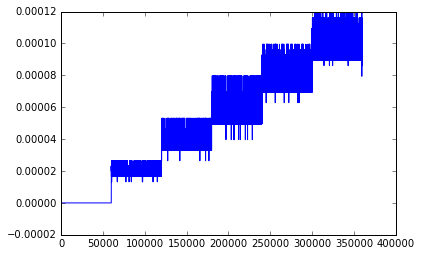

In [220]:
plt.plot(np.array(h_new['train/time']) - np.array(h_old['train/time'])[:len(h_new['train/time'])])

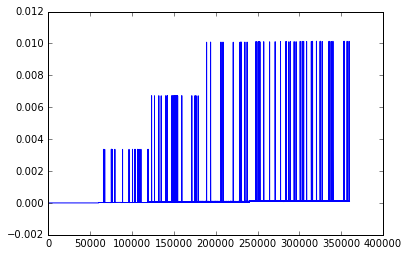

In [221]:
plt.plot(np.array(f_new['train/time']) - np.array(f_corrupt['train/time'])[:len(f_new['train/time'])])

In [222]:
f_new.close()
f_corrupt.close()
h_new.close()
h_old.close()